Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - accuracy: 0.2716 - loss: 2.1034 - val_accuracy: 0.7867 - val_loss: 1.1535
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.7733 - loss: 1.0289 - val_accuracy: 0.9100 - val_loss: 0.5300
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.8621 - loss: 0.5582 - val_accuracy: 0.9300 - val_loss: 0.3224
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.9002 - loss: 0.3729 - val_accuracy: 0.9433 - val_loss: 0.2483
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9213 - loss: 0.2972 - val_accuracy: 0.9500 - val_loss: 0.2067
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 854ms/step - accuracy: 0.9482 - loss: 0.2421
Test accuracy: 0.9533, Test loss: 0.2024
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step 
[[27  0  0  0  0  1  0  0  0  2]
 [ 1 29  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  

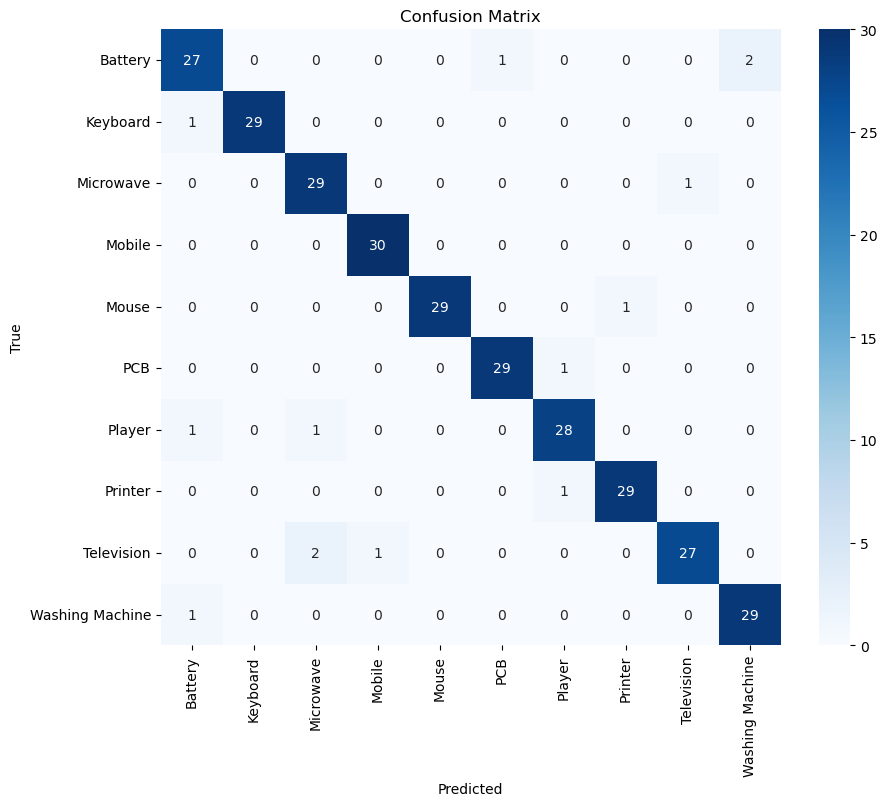

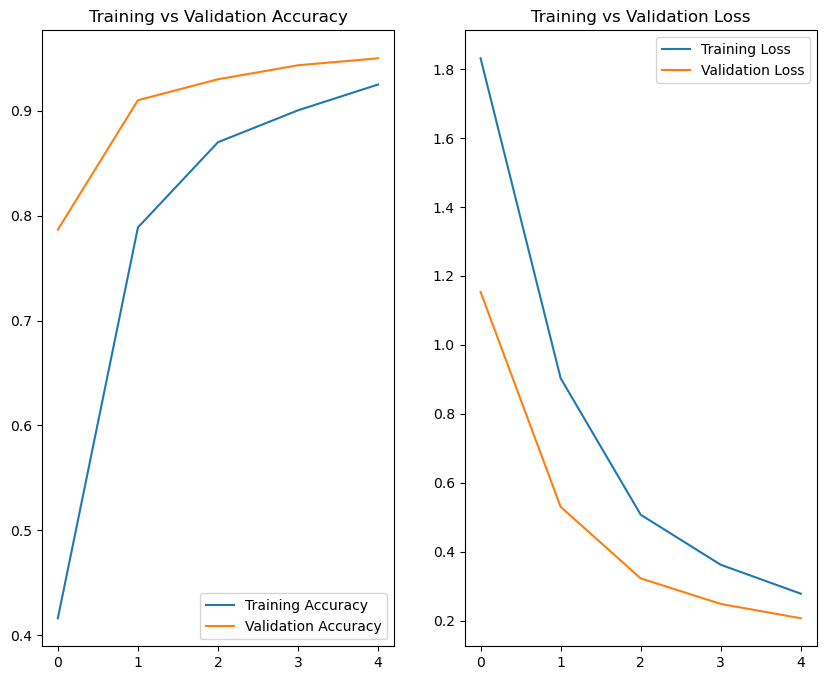

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr
from PIL import Image

#  dataset paths
trainpath = r'C:\Users\rahul j\Downloads\E-Waste classification dataset\modified-dataset\train'
testpath = r'C:\Users\rahul j\Downloads\E-Waste classification dataset\modified-dataset\test'
validpath = r'C:\Users\rahul j\Downloads\E-Waste classification dataset\modified-dataset\val'

#  Dataset loading (unchanged)
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath,shuffle=True,image_size=(128,128),batch_size=32)
datatest = tf.keras.utils.image_dataset_from_directory(testpath,shuffle=False,image_size=(128,128),batch_size=32)
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle=True,image_size=(128,128),batch_size=32)

class_names = datatrain.class_names

#  Feature 1: Data Augmentation
augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

#  Feature 2: EarlyStopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

#  Feature 3: Label Smoothing in Loss Function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()

#  Feature 4: Add dropout + augment to your model (minimal structure change)
base_model = EfficientNetV2B0(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

model = tf.keras.Sequential([
    layers.Input(shape=(128, 128, 3)),
    augment,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss=loss_fn, metrics=['accuracy'])

#  Training with EarlyStopping
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=5,
    callbacks=[early]
)

# Evaluate
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy: {accuracy:.4f}, Test loss: {loss:.4f}')

# Confusion matrix and classification report
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)
y_pred_probs = model.predict(datatest)
y_pred = np.argmax(y_pred_probs, axis=1)
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy and Loss plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

#  Feature 5: Top-3 Prediction Gradio Interface
def classify_image(img):
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0]
    top3 = prediction.argsort()[-3:][::-1]
    return {class_names[i]: float(prediction[i]) for i in top3}

iface = gr.Interface(fn=classify_image, inputs=gr.Image(type="pil"), outputs=gr.Label(num_top_classes=3))
iface.launch()

# Save model
model.save('Efficient_classify_enhanced.keras')
